# Post Data Analysis

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import math

plt.rcParams["figure.figsize"] = (20, 10)


## Load Data
### Set start and end points
By examine output data

In [24]:
# set results path
results_file = "data_out_simple_nozzle_run_firing.csv"

startPoint = 108000 # ms
endPoint = 148394 # ms

data = pd.read_csv(results_file)
duration = data["timestamp"].isin(range(startPoint, endPoint))
data = data[duration]

data_np = data.to_numpy()


### A quick overview of the raw data, check if any sensors are installed in the wrong orientation


check correlation matrix

IMU results from the two sensors should be negatively correlated on X and Y axises respectively, and positively correlated on Z axis, based on physical installation of the sensors. Should be careful if user decided to install sensors differently.

A strong correlation of same feature in the two set IMU results would indicate the endpoint had moved or rotated in that direction significantly. Otherwise, it means the motion or rotation in specific direction was no more than stationary noise of IMU sensors.


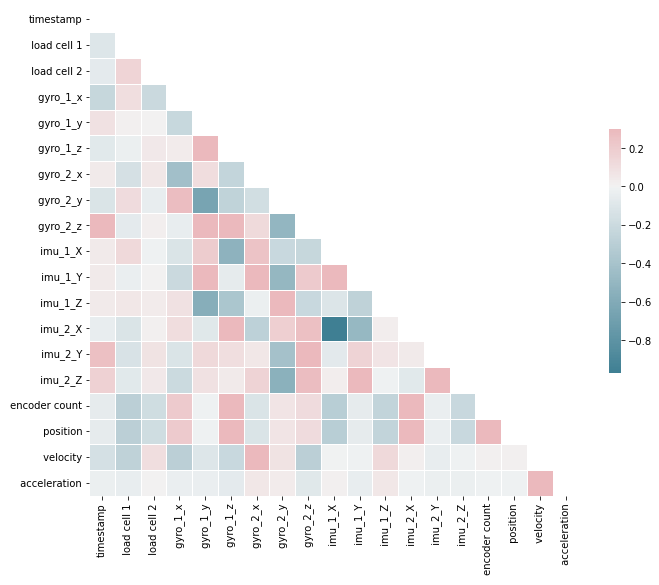

In [25]:
corr_mat = data.corr()
mask = np.zeros_like(corr_mat, dtype=bool) 
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Actual pairwise chart. Takes a long time to render, uncomment and run if want to.

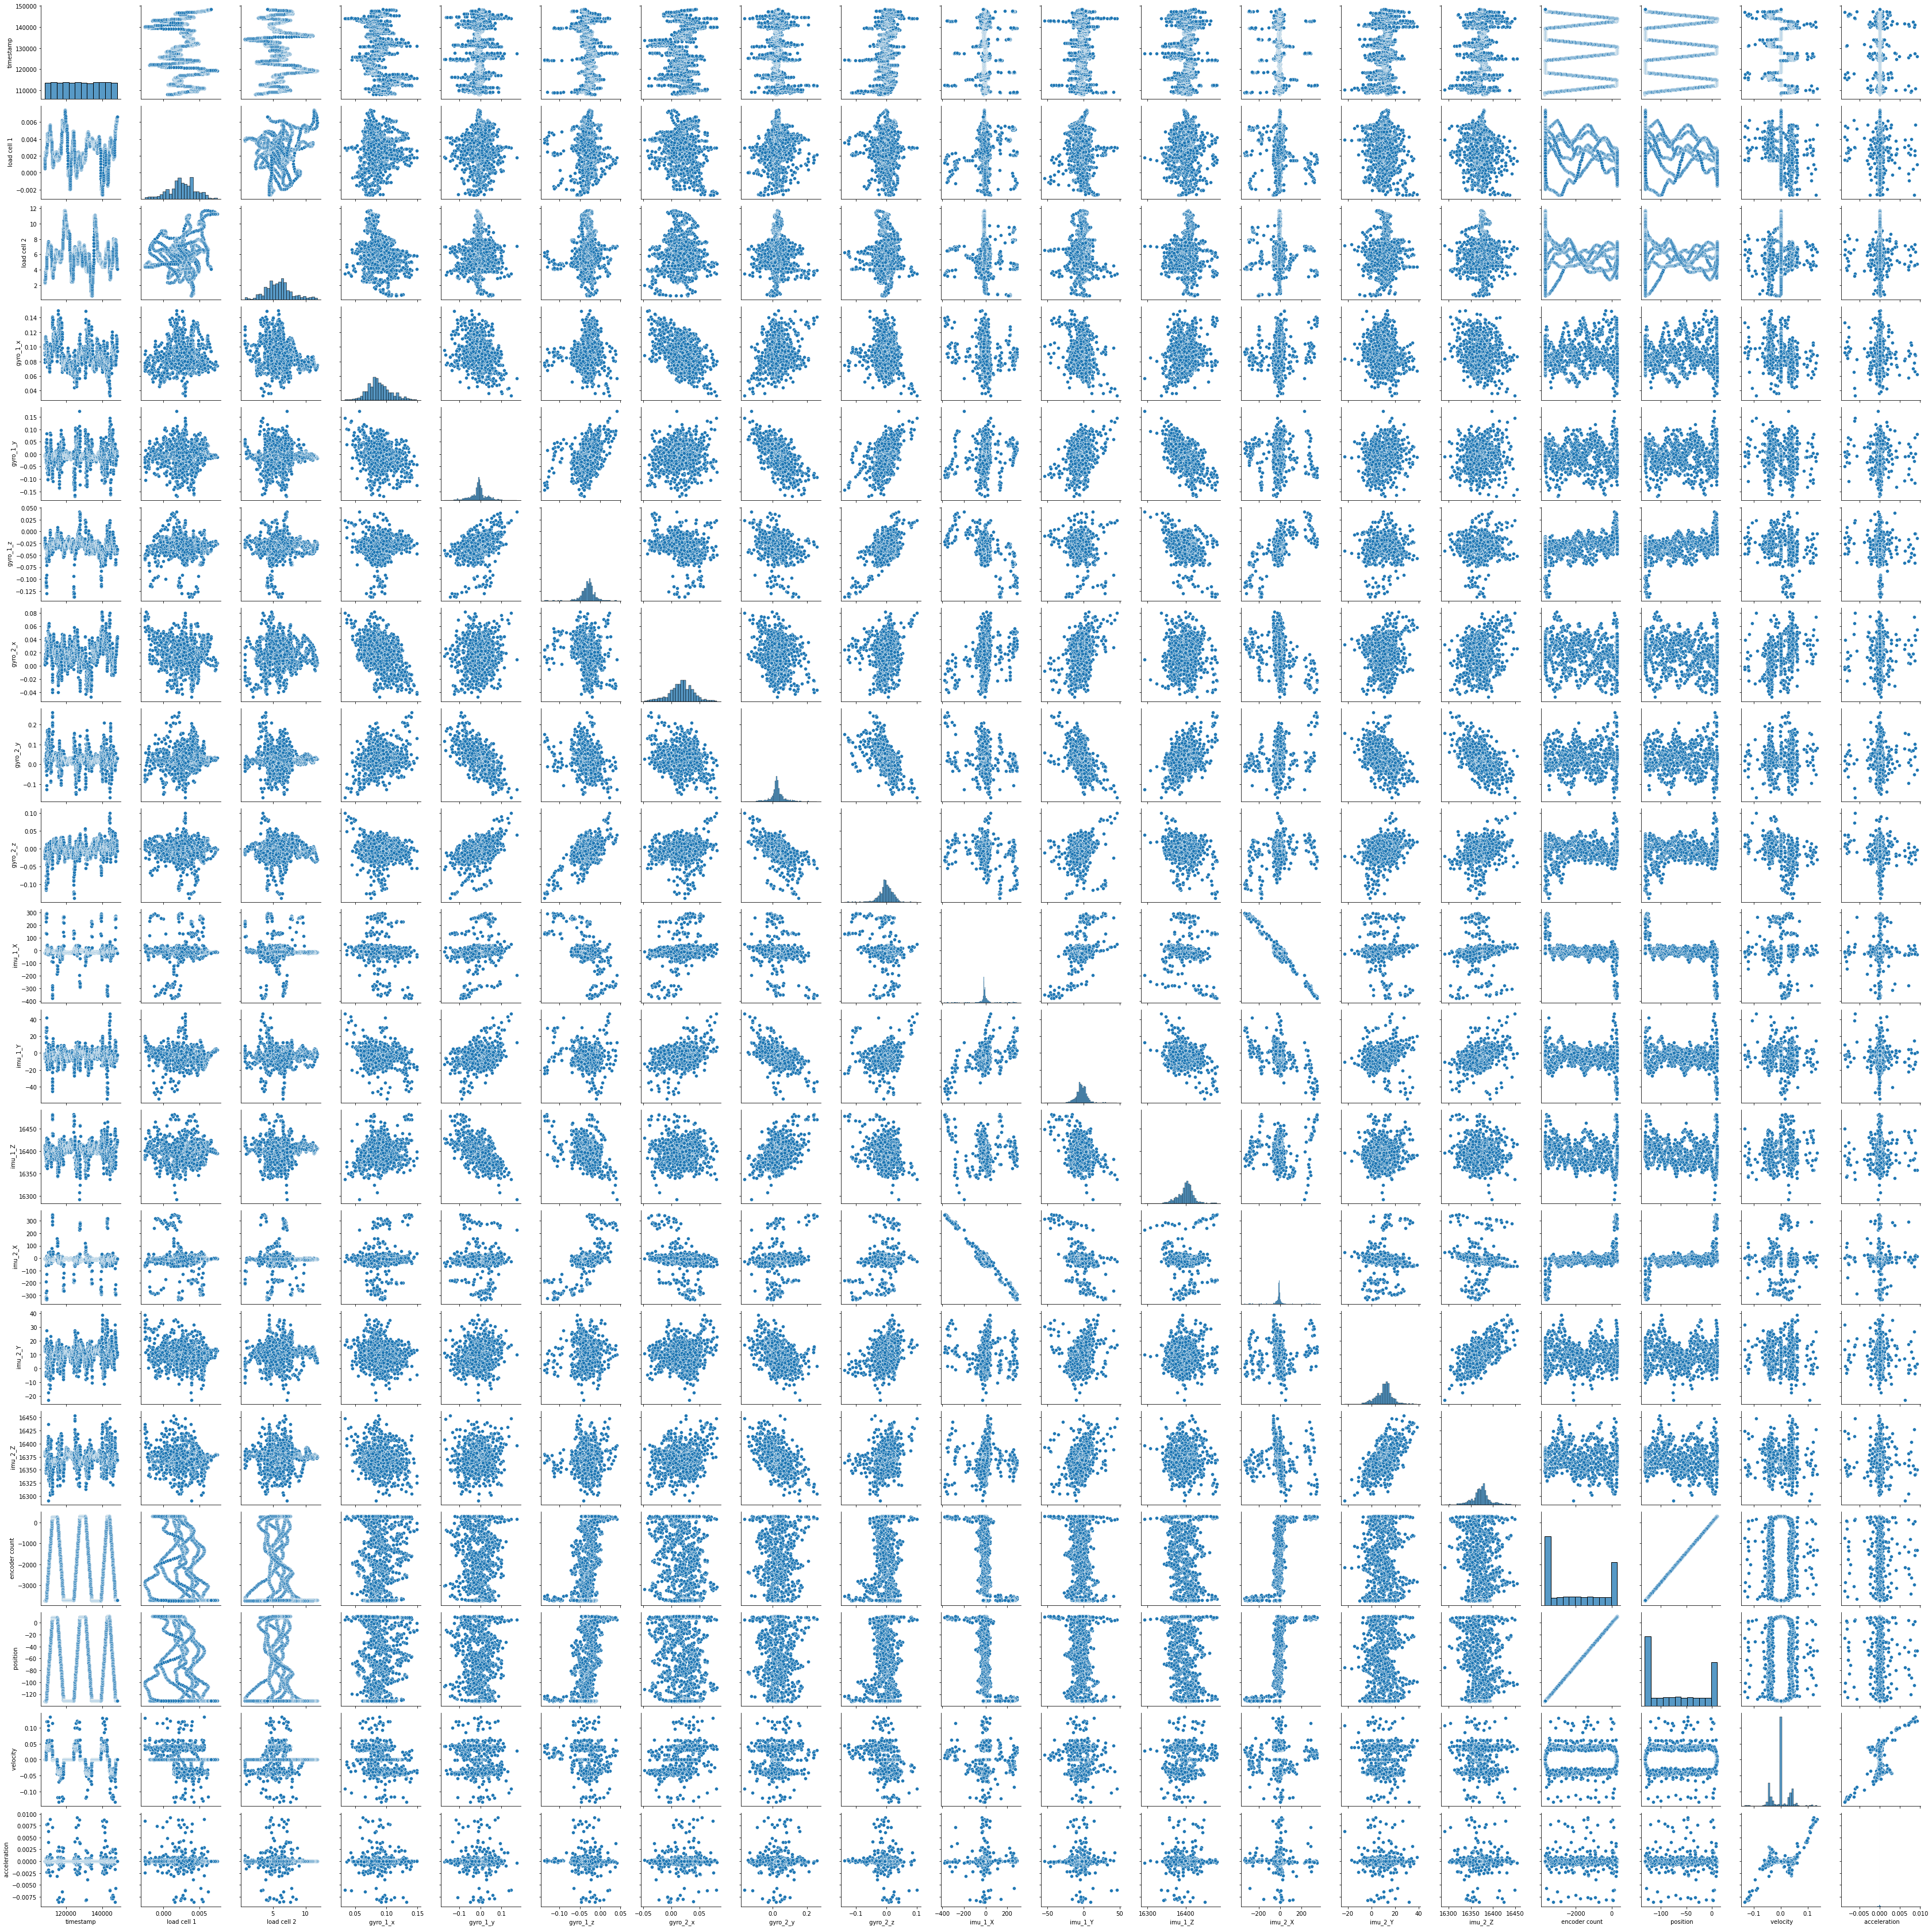

In [26]:
sns.pairplot(data)
plt.show()


## Analise Linear Encoder Results

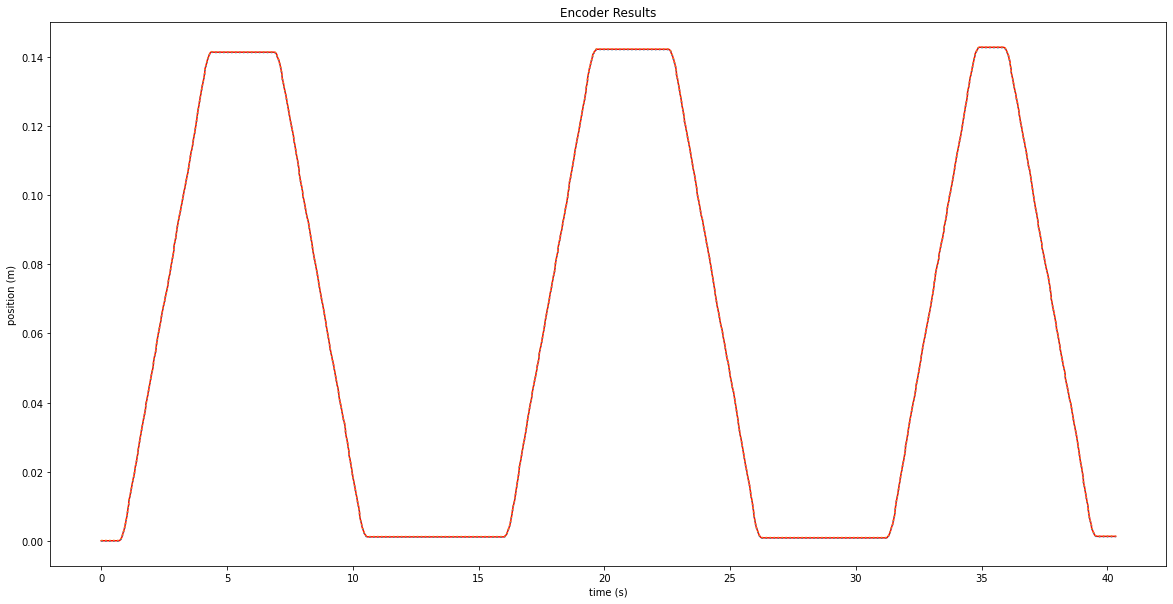

In [27]:
# set specs of encoder
resolution = 35.27777778 / 1000000 # in m
uncertainty = 93.4498 / 1000000 # in m

time = data_np[:, 0]
time = time - time[0] # in ms
time = time / 1000 # in s

position = data_np[:, 15]
position = position - position[0] # zero the measurement
# assument starting position as at 0 micron, encoder resolution is 35.27777778 microns and uncertainty (including initial position within one resolution) is +- 93.4498 microns

position = position * resolution
position_lower_bound = position - uncertainty
position_upper_bound = position + uncertainty


# plot position
plt.plot(time, position, 'r')
plt.plot(time, position_lower_bound, ':')
plt.plot(time, position_upper_bound, ':')
plt.title("Encoder Results")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.show()


### Velocity estimation from encoder data


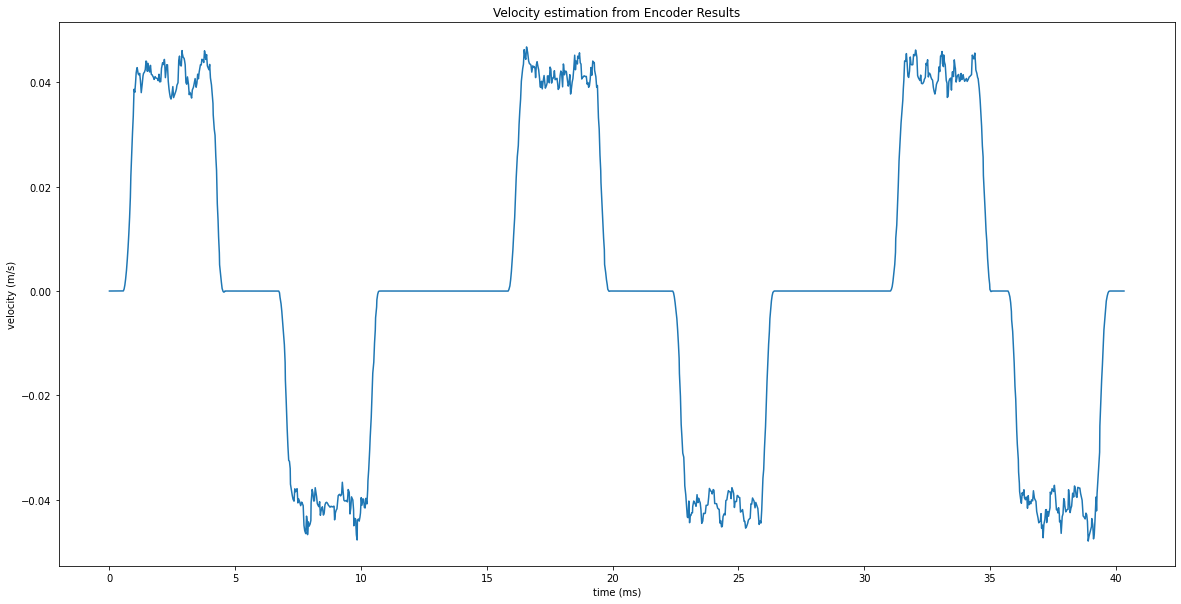

In [28]:
velocity = np.array([float(0)] * time.size)
smooth_factor = 5
for i in range(smooth_factor):
    for j in [1+i, -2-i]:
        velocity[j] = (position[j+1+i] - position[j-1-i])/(time[j+1+i] - time[j-1-i])

for i in range(smooth_factor, time.size-1-smooth_factor):
    velocity[i] = (position[i+smooth_factor] - position[i-smooth_factor])/(time[i+smooth_factor] - time[i-smooth_factor])
plt.plot(time, velocity)
plt.title("Velocity estimation from Encoder Results")
plt.xlabel("time (ms)")
plt.ylabel("velocity (m/s)")
plt.show()

### Acceleration estimation from encoder velocity estimation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


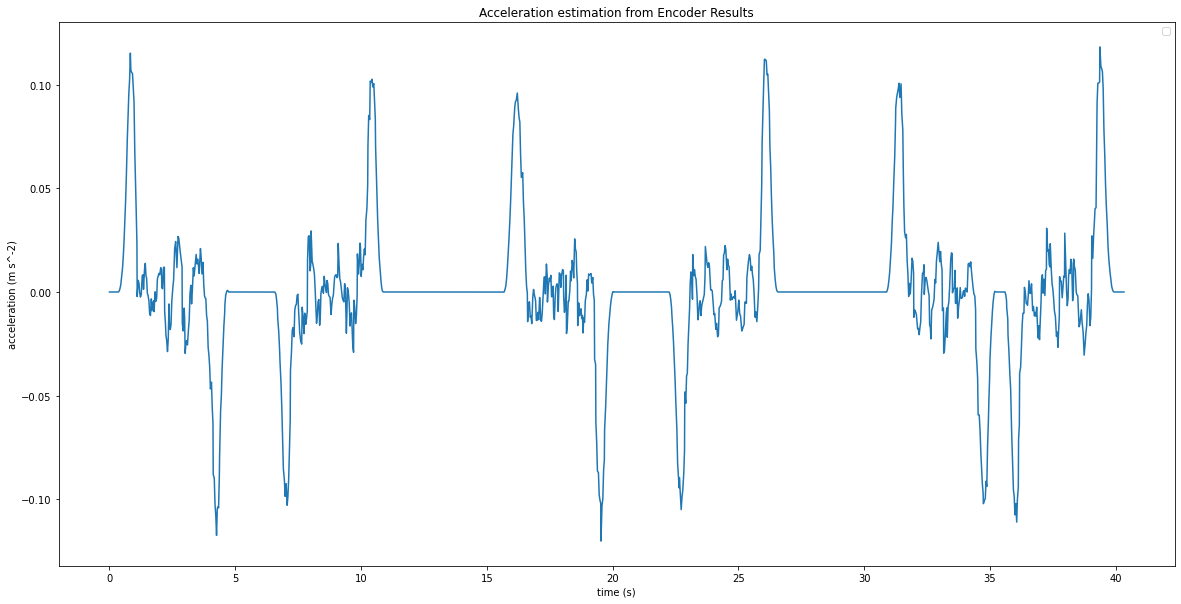

In [29]:
acceleration = np.array([float(0)] * time.size)
smooth_factor = 5
for i in range(smooth_factor):
    for j in [1+i, -2-i]:
        acceleration[j] = (velocity[j+1+i] - velocity[j-1-i])/(time[j+1+i] - time[j-1-i])

for i in range(smooth_factor, time.size-1-smooth_factor):
    acceleration[i] = (velocity[i+smooth_factor] - velocity[i-smooth_factor])/(time[i+smooth_factor] - time[i-smooth_factor])
plt.plot(time, acceleration)
plt.title("Acceleration estimation from Encoder Results")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
# plt.ylim((-0.1, 0.1))
plt.legend(loc="upper right")
plt.show()

## IMU Results

### Acceleration on x direction


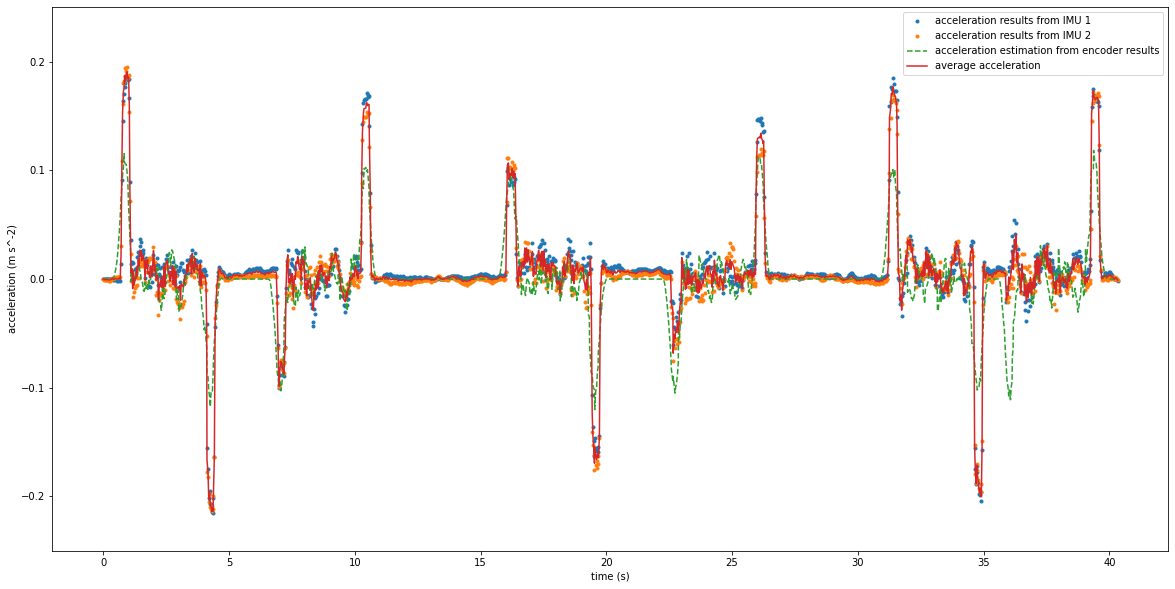

In [131]:
g = 9.8

acc1 = data_np[:, 9] / 16384 * g
acc1 = acc1 - acc1[0]
acc2 = data_np[:, 12] * (-1) / 16384 * g
acc2 = acc2 - acc2[0]
x_acc = (acc1 + acc2)/2


plt.plot(time, acc1, '.', label="acceleration results from IMU 1")
plt.plot(time, acc2, '.', label="acceleration results from IMU 2")
plt.plot(time, acceleration, "--", label="acceleration estimation from encoder results")
plt.plot(time, x_acc, label="average acceleration")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
plt.ylim((-0.25, 0.25))
plt.legend(loc="upper right")
plt.show()

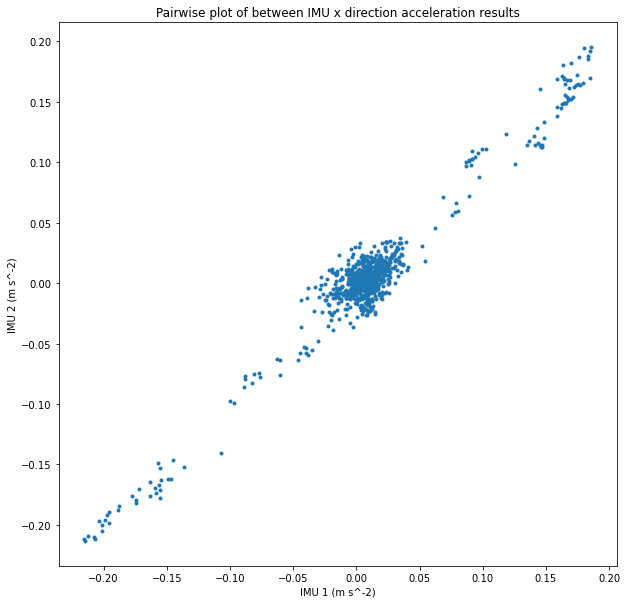

In [132]:
# pairwise between IMU1 results and IMU2 results
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(acc1, acc2, '.')
plt.title("Pairwise plot of between IMU x direction acceleration results")
plt.xlabel("IMU 1 (m s^-2)")
plt.ylabel("IMU 2 (m s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)

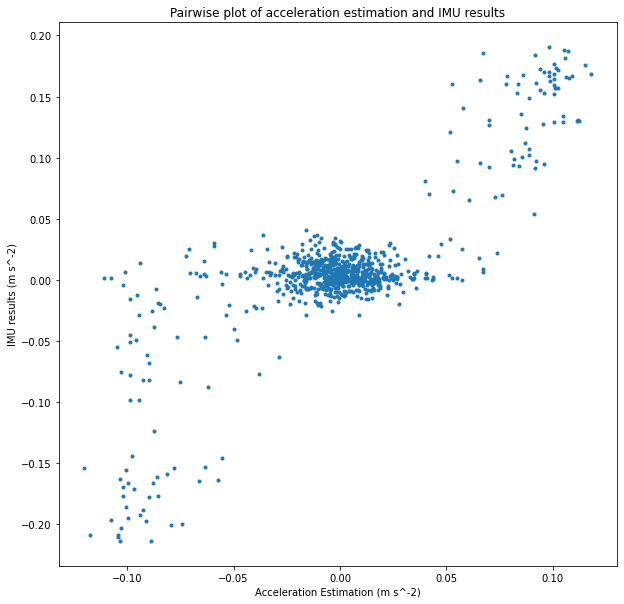

In [133]:
# pairwise between IMU results and acceleration estimation
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(acceleration, x_acc, '.')
plt.title("Pairwise plot of acceleration estimation and IMU results")
plt.xlabel("Acceleration Estimation (m s^-2)")
plt.ylabel("IMU results (m s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)

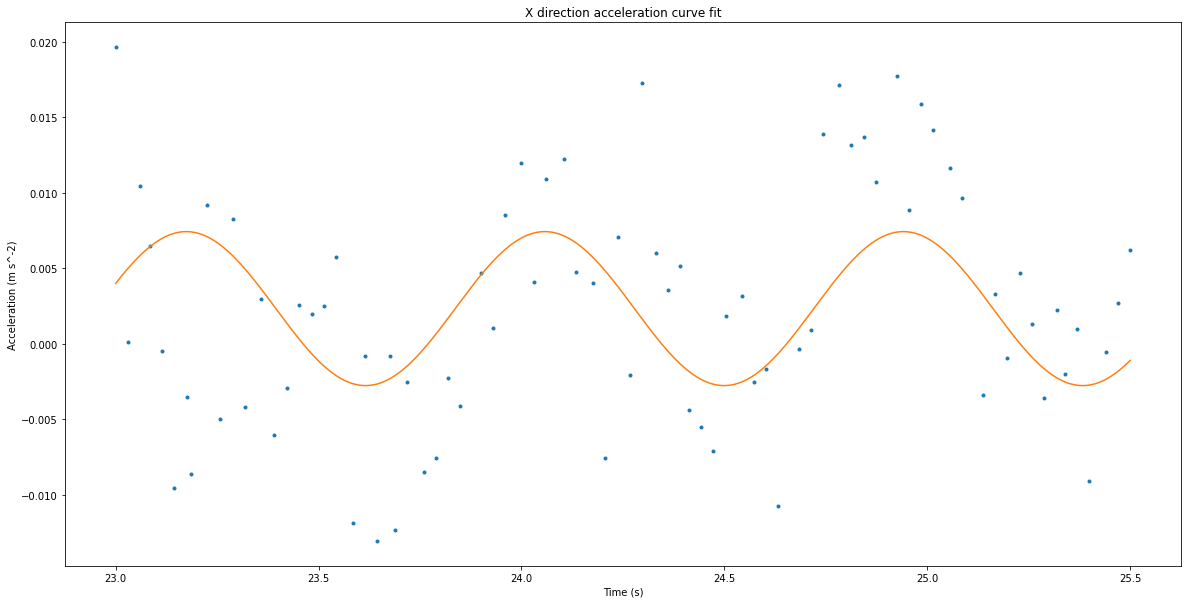

X direction vibration estimation
Amplitute: 100.84721153348242 microns
Frequency: 1.1318078645367478 Hz


In [134]:
# fit sine curve
start = 23 # s
end = 25.5
# estimation from graph
A = 0.02
f = 1
d = 0


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = x_acc[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi, d):
    return A*np.sin(2*math.pi*f*t + phi) + d

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1, d])



A = params[0]
f = params[1]
phi = params[2]
d = params[3]



plt.plot(t, y, '.', label="IMU results")
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi) + d, label="Estimation")
plt.title("X direction acceleration curve fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m s^-2)")
plt.show()


print("X direction vibration estimation")
print(f"Amplitute: {abs(A/(2*math.pi*f)**2) * (10 ** 6)} microns")
print(f"Frequency: {f} Hz")



### accelerometer in y and z direction

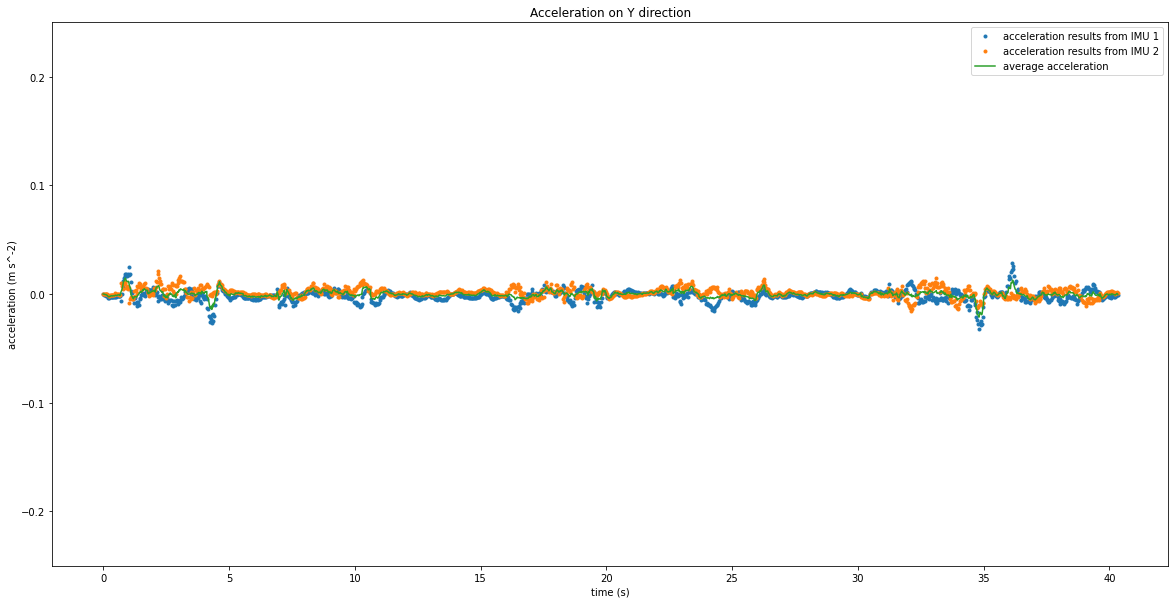

In [199]:
acc1 = data_np[:, 10] / 16384 * g
acc1 = acc1 - acc1[0]
acc2 = data_np[:, 13] / 16384 * g *(-1)
acc2 = acc2 - acc2[0]
y_acc = (acc1 + acc2)/2

plt.title("Acceleration on Y direction")
plt.plot(time, acc1, '.', label="acceleration results from IMU 1")
plt.plot(time, acc2, '.', label="acceleration results from IMU 2")
plt.plot(time, y_acc, label="average acceleration")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
plt.ylim((-0.25, 0.25))
plt.legend(loc="upper right")
plt.show()

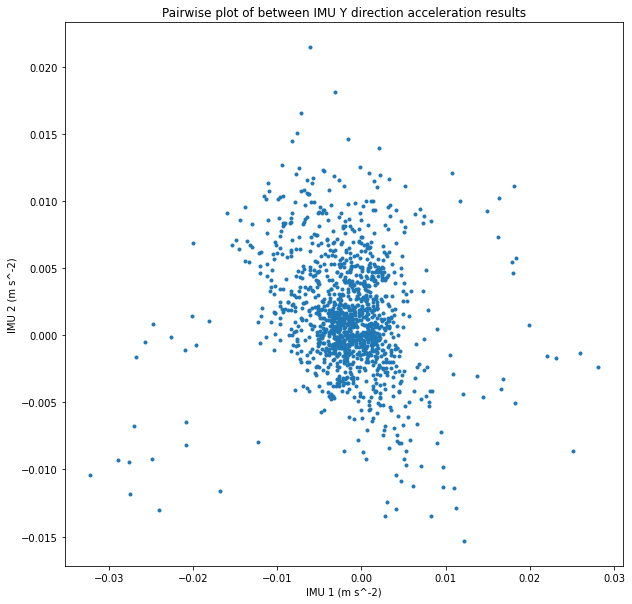

In [200]:
# pairwise between IMU1 results and IMU2 results
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(acc1, acc2, '.')
plt.title("Pairwise plot of between IMU Y direction acceleration results")
plt.xlabel("IMU 1 (m s^-2)")
plt.ylabel("IMU 2 (m s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)

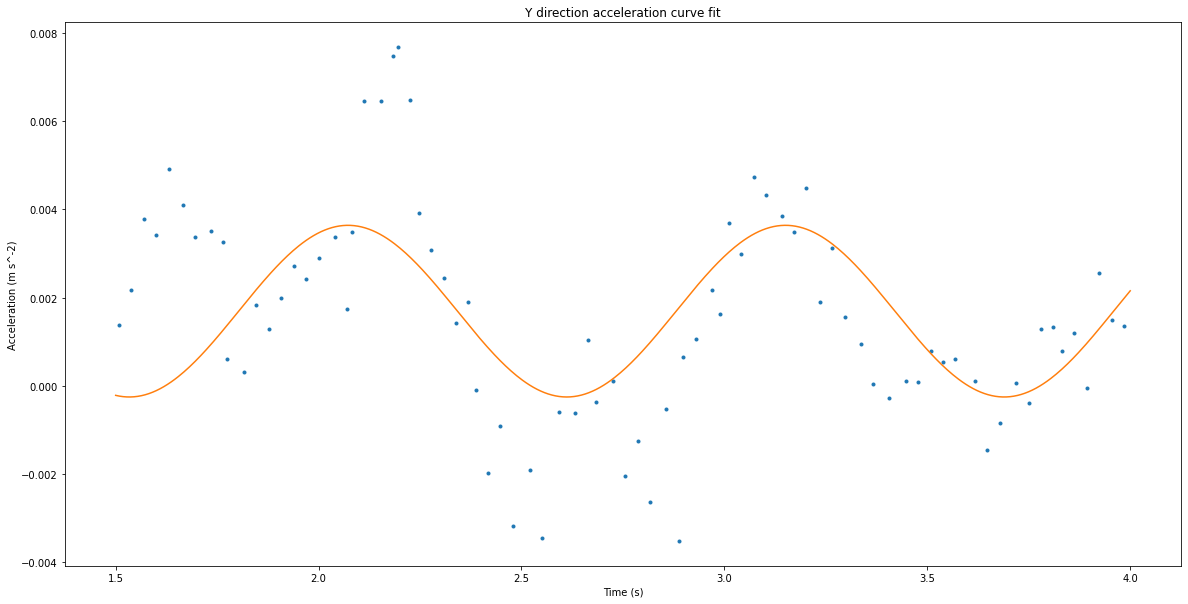

Y direction vibration estimation
Amplitute: 57.40271954699129 microns
Frequency: 0.9276902588485189 Hz


In [221]:
# fit sine curve
start = 1.5 # s
end = 4
# estimation from graph
A = 0.02
f = 1
d = 0


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = y_acc[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi, d):
    return A*np.sin(2*math.pi*f*t + phi) + d

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1, d])



A = params[0]
f = params[1]
phi = params[2]
d = params[3]



plt.plot(t, y, '.', label="IMU results")
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi) + d, label="Estimation")
plt.title("Y direction acceleration curve fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m s^-2)")
plt.show()


print("Y direction vibration estimation")
print(f"Amplitute: {abs(A/(2*math.pi*f)**2) * (10 ** 6)} microns")
print(f"Frequency: {f} Hz")

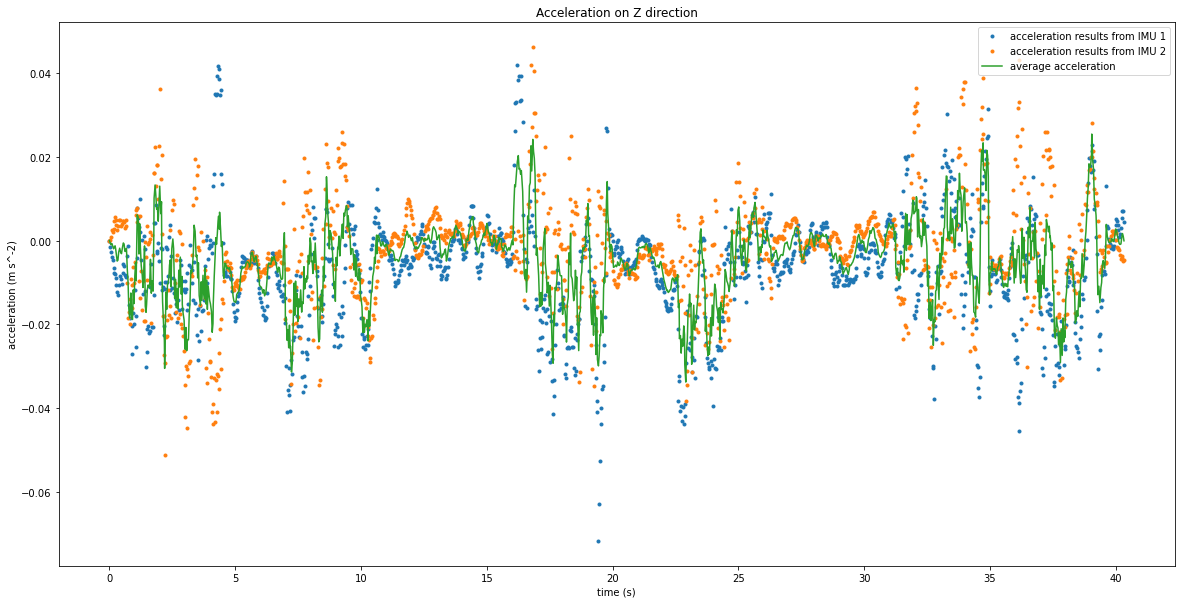

In [248]:
acc1 = data_np[:, 11] / 16384 * g
acc1 = acc1 - acc1[0]
acc2 = data_np[:, 14] / 16384 * g
acc2 = acc2 - acc2[0]
z_acc = (acc1 + acc2)/2

plt.title("Acceleration on Z direction")
plt.plot(time, acc1, '.', label="acceleration results from IMU 1")
plt.plot(time, acc2, '.', label="acceleration results from IMU 2")
plt.plot(time, z_acc, label="average acceleration")
plt.xlabel("time (s)")
plt.ylabel("acceleration (m s^-2)")
# plt.ylim((-0.25, 0.25))
plt.legend(loc="upper right")
plt.show()

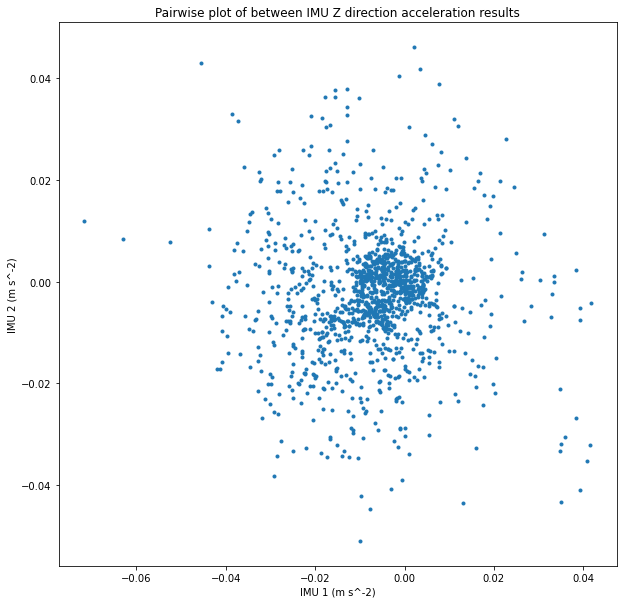

In [249]:
# pairwise between IMU1 results and IMU2 results
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(acc1, acc2, '.')
plt.title("Pairwise plot of between IMU Z direction acceleration results")
plt.xlabel("IMU 1 (m s^-2)")
plt.ylabel("IMU 2 (m s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)

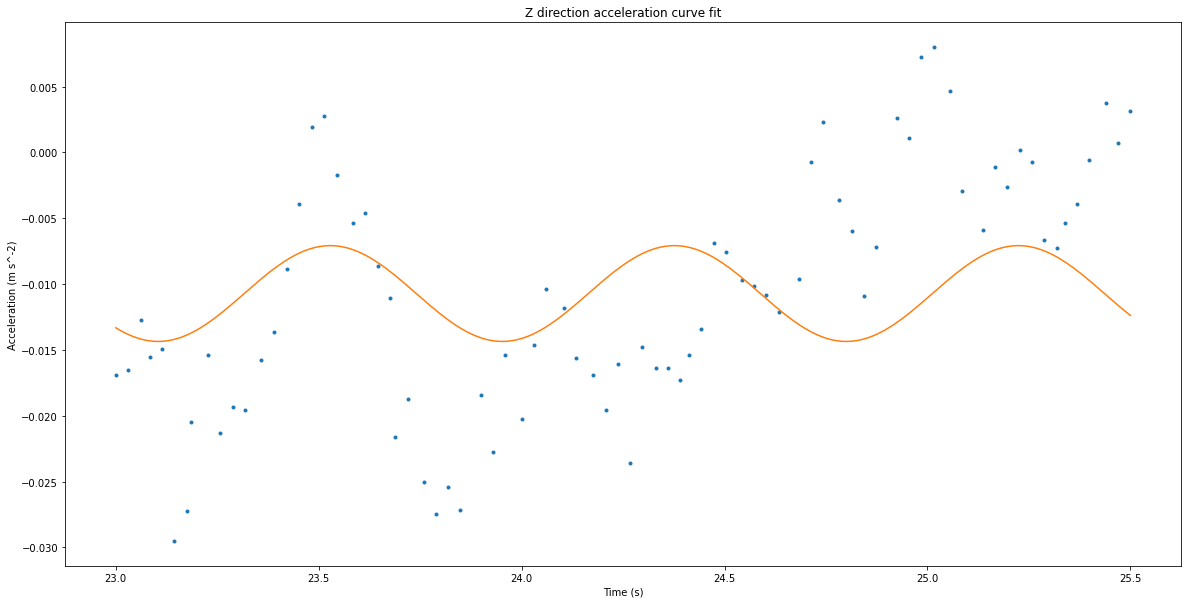

Z direction vibration estimation
Amplitute: 66.27707270303867 microns
Frequency: 1.1794268282632034 Hz


In [250]:
# fit sine curve
start = 23 # s
end = 25.5
# estimation from graph
A = 0.02
f = 1
d = 0


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = z_acc[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi, d):
    return A*np.sin(2*math.pi*f*t + phi) + d

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1, d])



A = params[0]
f = params[1]
phi = params[2]
d = params[3]



plt.plot(t, y, '.', label="IMU results")
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi) + d, label="Estimation")
plt.title("Z direction acceleration curve fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m s^-2)")
plt.show()


print("Z direction vibration estimation")
print(f"Amplitute: {abs(A/(2*math.pi*f)**2) * (10 ** 6)} microns")
print(f"Frequency: {f} Hz")

## Rotational Results

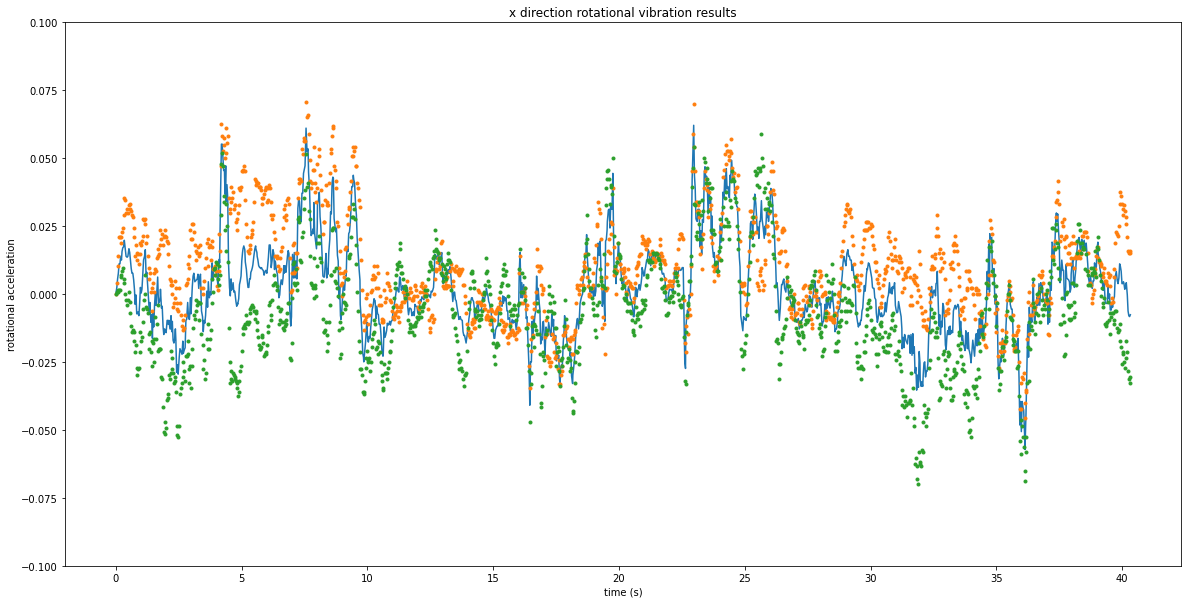

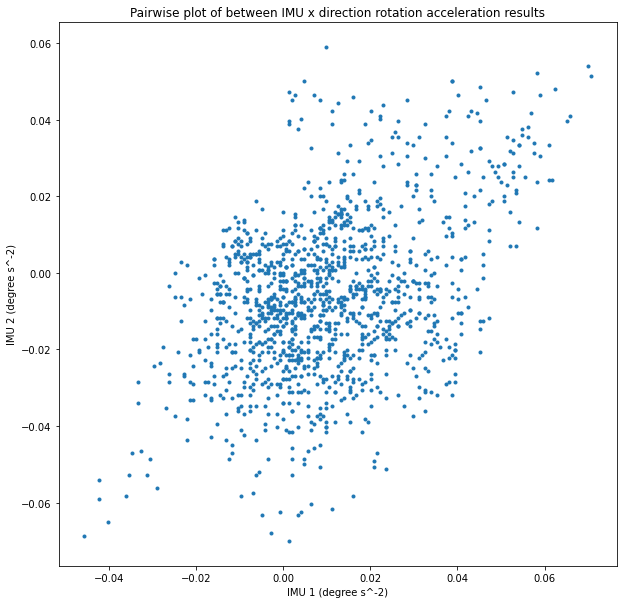

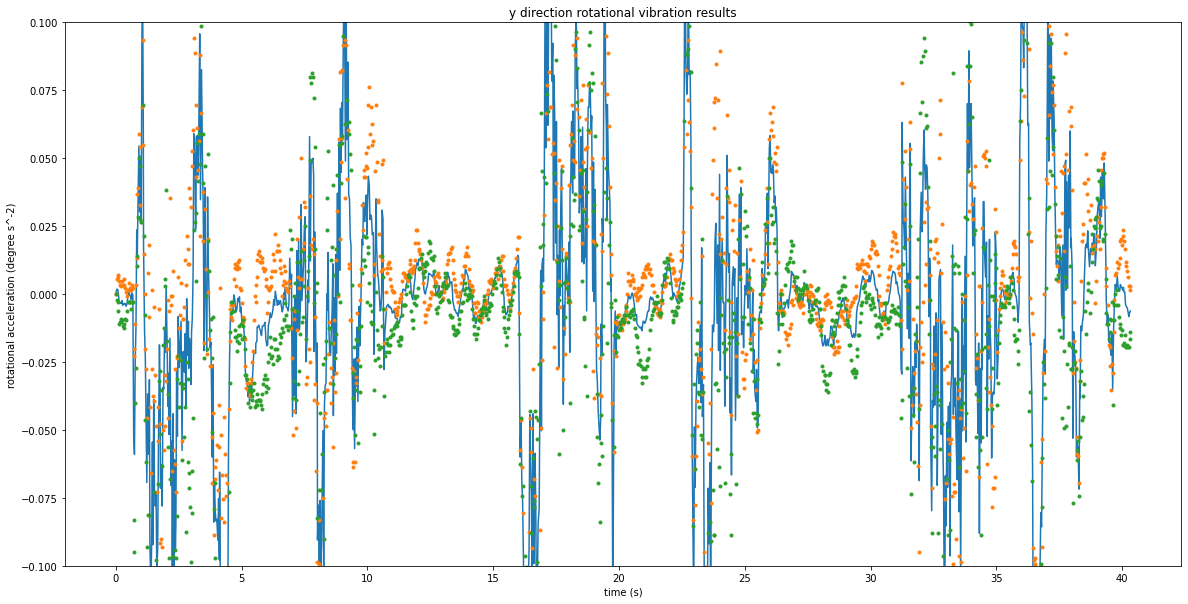

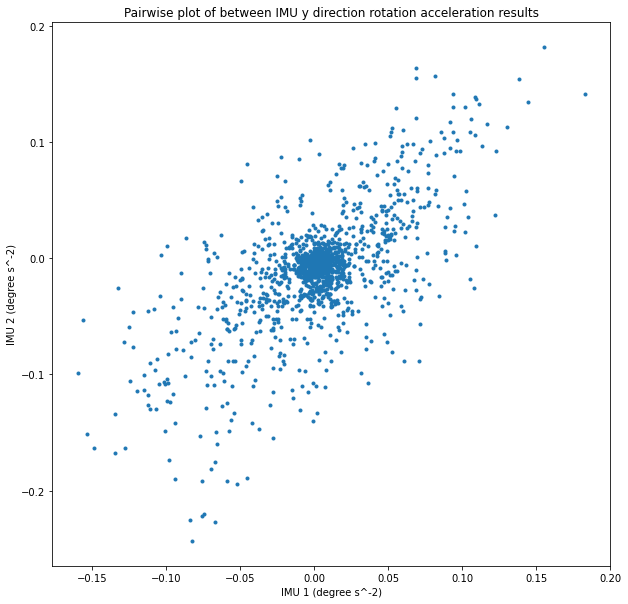

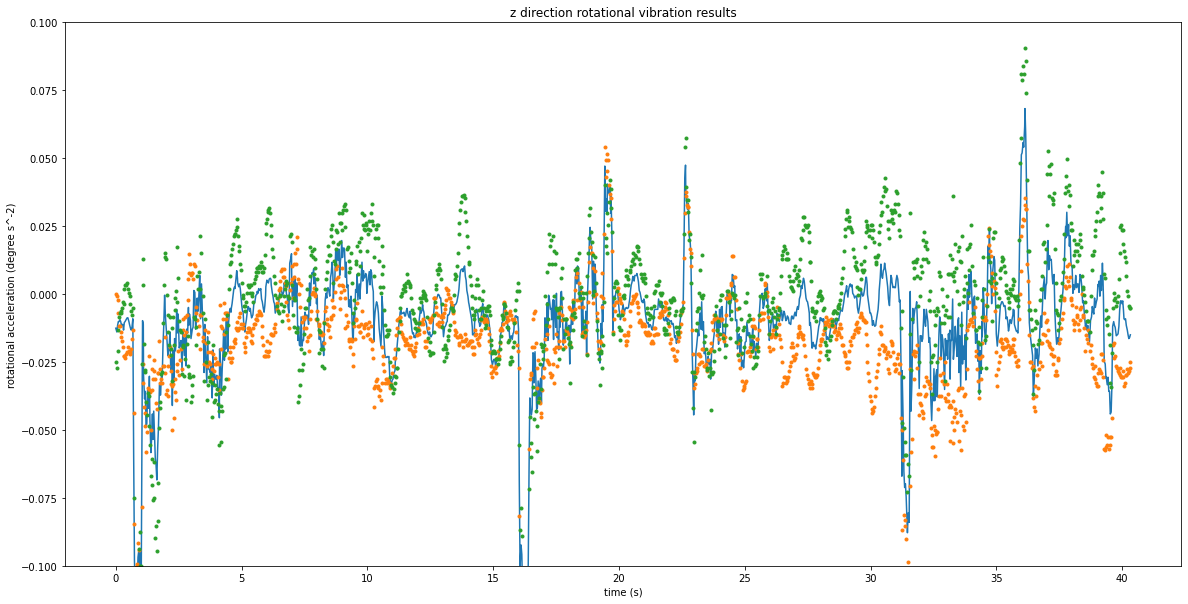

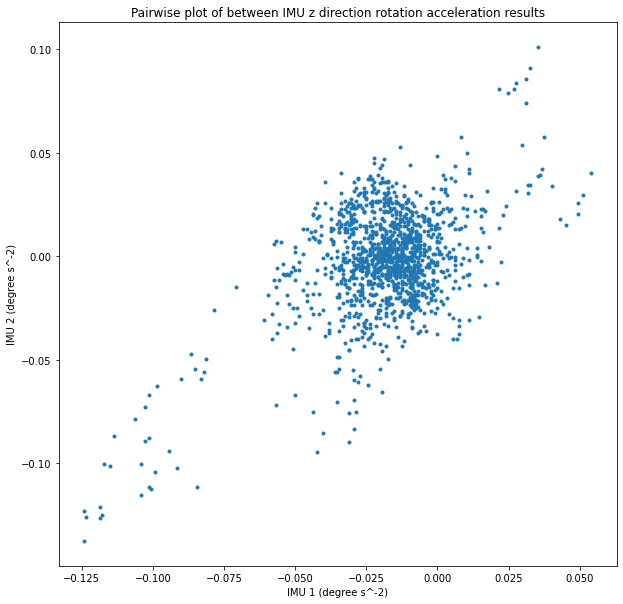

In [268]:
# rotation on x direction
rot1 = data_np[:, 3]
rot1 = rot1 - rot1[0]
rot2 = data_np[:, 6] * (-1)
rot2 = rot2 - rot2[0]
x_rot = (rot1 + rot2)/2

plt.plot(time, x_rot, label="average")
plt.plot(time, rot1, '.', label="IMU 1")
plt.plot(time, rot2, '.', label="IMU 2")
plt.ylim((-0.1, 0.1))
plt.xlabel("time (s)")
plt.ylabel("rotational acceleration")
plt.title("x direction rotational vibration results")
plt.show()

# pairwise between IMU1 results and IMU2 results
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(rot1, rot2, '.')
plt.title("Pairwise plot of between IMU x direction rotation acceleration results")
plt.xlabel("IMU 1 (degree s^-2)")
plt.ylabel("IMU 2 (degree s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)

# rotation on y direction
rot1 = data_np[:, 4]
rot1 = rot1 - rot1[0]
rot2 = data_np[:, 7] * (-1)
rot2 = rot2 - rot2[0]
y_rot = (rot1 + rot2)/2

plt.plot(time, y_rot, label="average")
plt.plot(time, rot1, '.', label="IMU 1")
plt.plot(time, rot2, '.', label="IMU 2")
plt.ylim((-0.1, 0.1))
plt.xlabel("time (s)")
plt.ylabel("rotational acceleration (degree s^-2)")
plt.title("y direction rotational vibration results")
plt.show()

# pairwise between IMU1 results and IMU2 results
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(rot1, rot2, '.')
plt.title("Pairwise plot of between IMU y direction rotation acceleration results")
plt.xlabel("IMU 1 (degree s^-2)")
plt.ylabel("IMU 2 (degree s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)

# rotation on z direction
rot1 = data_np[:, 5]
rot1 = rot1 - rot1[0]
rot2 = data_np[:, 8] 
rot2 = rot2 - rot1[0]
z_rot = (rot1 + rot2)/2

plt.plot(time, z_rot, label="average")
plt.plot(time, rot1, '.', label="IMU 1")
plt.plot(time, rot2, '.', label="IMU 2")
plt.ylim((-0.1, 0.1))
plt.xlabel("time (s)")
plt.ylabel("rotational acceleration (degree s^-2)")
plt.title("z direction rotational vibration results")
plt.show()

# pairwise between IMU1 results and IMU2 results
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(rot1, rot2, '.')
plt.title("Pairwise plot of between IMU z direction rotation acceleration results")
plt.xlabel("IMU 1 (degree s^-2)")
plt.ylabel("IMU 2 (degree s^-2)")
plt.show()
plt.rcParams["figure.figsize"] = (20, 10)


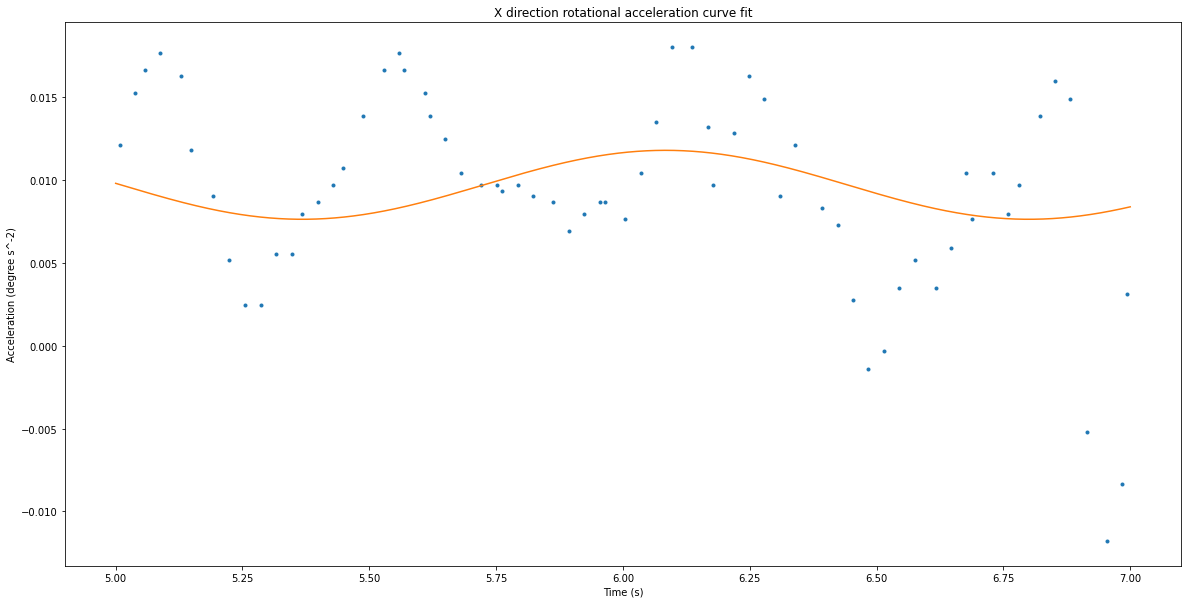

X direction rotation vibration estimation
Amplitute: 0.00010810670122930788 degree
Frequency: 0.6982397935019947 Hz


In [269]:
## fit sine curve
start = 5 # s
end = 7
# estimation from graph
A = 0.02
f = 1
d = 0


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = x_rot[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi, d):
    return A*np.sin(2*math.pi*f*t + phi) + d

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1, d])



A = params[0]
f = params[1]
phi = params[2]
d = params[3]



plt.plot(t, y, '.', label="IMU results")
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi) + d, label="Estimation")
plt.title("X direction rotational acceleration curve fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (degree s^-2)")
plt.show()


print("X direction rotation vibration estimation")
print(f"Amplitute: {abs(A/(2*math.pi*f)**2)} degree")
print(f"Frequency: {f} Hz")

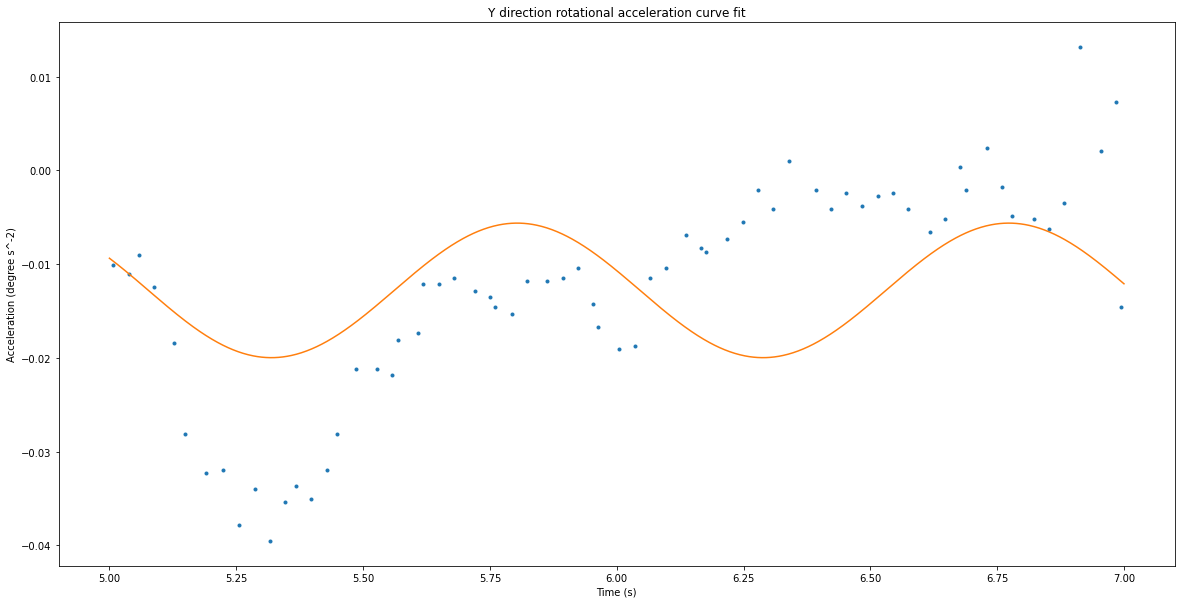

Y direction rotation vibration estimation
Amplitute: 0.00017072402968670335 degree
Frequency: 1.0318318825257784 Hz


In [270]:
## fit sine curve
start = 5 # s
end = 7
# estimation from graph
A = 0.02
f = 1
d = 0


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = y_rot[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi, d):
    return A*np.sin(2*math.pi*f*t + phi) + d

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1, d])



A = params[0]
f = params[1]
phi = params[2]
d = params[3]



plt.plot(t, y, '.', label="IMU results")
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi) + d, label="Estimation")
plt.title("Y direction rotational acceleration curve fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (degree s^-2)")
plt.show()


print("Y direction rotation vibration estimation")
print(f"Amplitute: {abs(A/(2*math.pi*f)**2)} degree")
print(f"Frequency: {f} Hz")

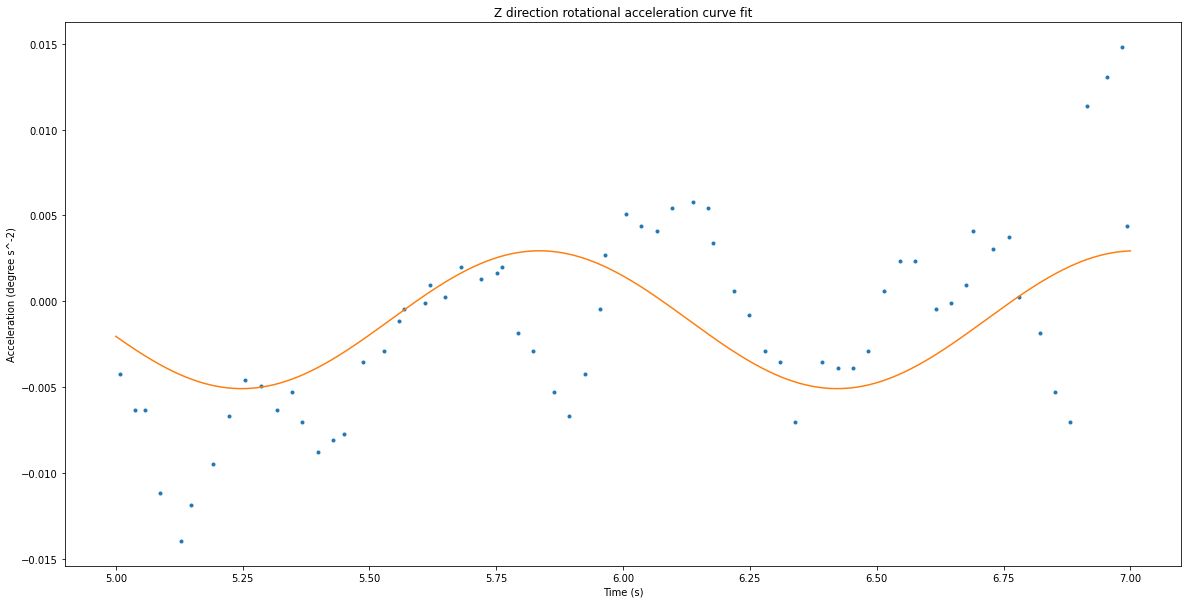

Z direction rotation vibration estimation
Amplitute: 0.00014014466358125817 degree
Frequency: 0.8517478064894338 Hz


In [271]:
## fit sine curve
start = 5 # s
end = 7
# estimation from graph
A = 0.02
f = 1
d = 0


# bounds = ((A[0],f[0], 0.01), (A[1],f[1], 2*math.pi))

t = time[(start <= time) & (time <= end)]
y = z_rot[(start <= time) & (time <= end)]


def sine_func(t, A, f, phi, d):
    return A*np.sin(2*math.pi*f*t + phi) + d

# params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[sum(A)/2, sum(f)/2, 0.1], bounds=bounds)
params, params_covariance = optimize.curve_fit(sine_func, t, y, p0=[A, f, 0.1, d])



A = params[0]
f = params[1]
phi = params[2]
d = params[3]



plt.plot(t, y, '.', label="IMU results")
t = np.linspace(start, end, num=int((start + end)/0.01), endpoint=True)
plt.plot(t, A*np.sin(2*math.pi*f*t + phi) + d, label="Estimation")
plt.title("Z direction rotational acceleration curve fit")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (degree s^-2)")
plt.show()


print("Z direction rotation vibration estimation")
print(f"Amplitute: {abs(A/(2*math.pi*f)**2)} degree")
print(f"Frequency: {f} Hz")

## Tension Results

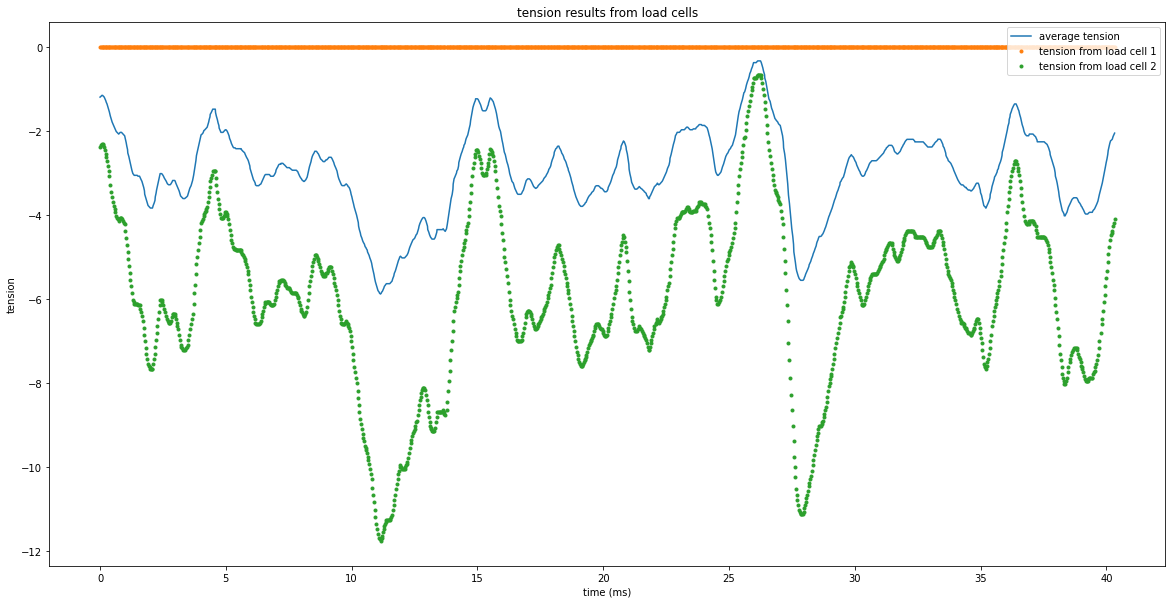

In [272]:

load1 = data_np[:, 1]
load2 = data_np[:, 2] * (-1)
tension = (load1 + load2) / 2
plt.plot(time, tension, label="average tension")
plt.plot(time, load1, '.', label="tension from load cell 1")
plt.plot(time, load2, '.', label="tension from load cell 2")
plt.xlabel("time (ms)")
plt.ylabel("tension")
plt.title("tension results from load cells")
plt.legend(loc="upper right")
plt.show()



## pairwise chart for everything

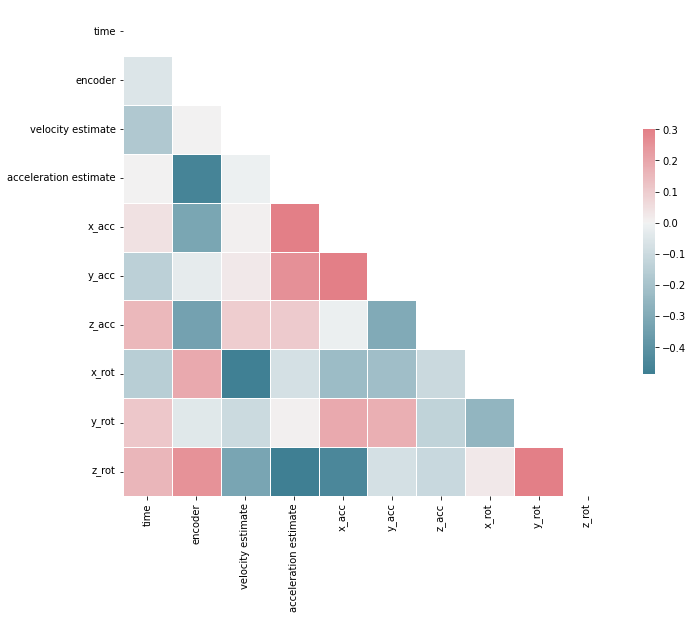

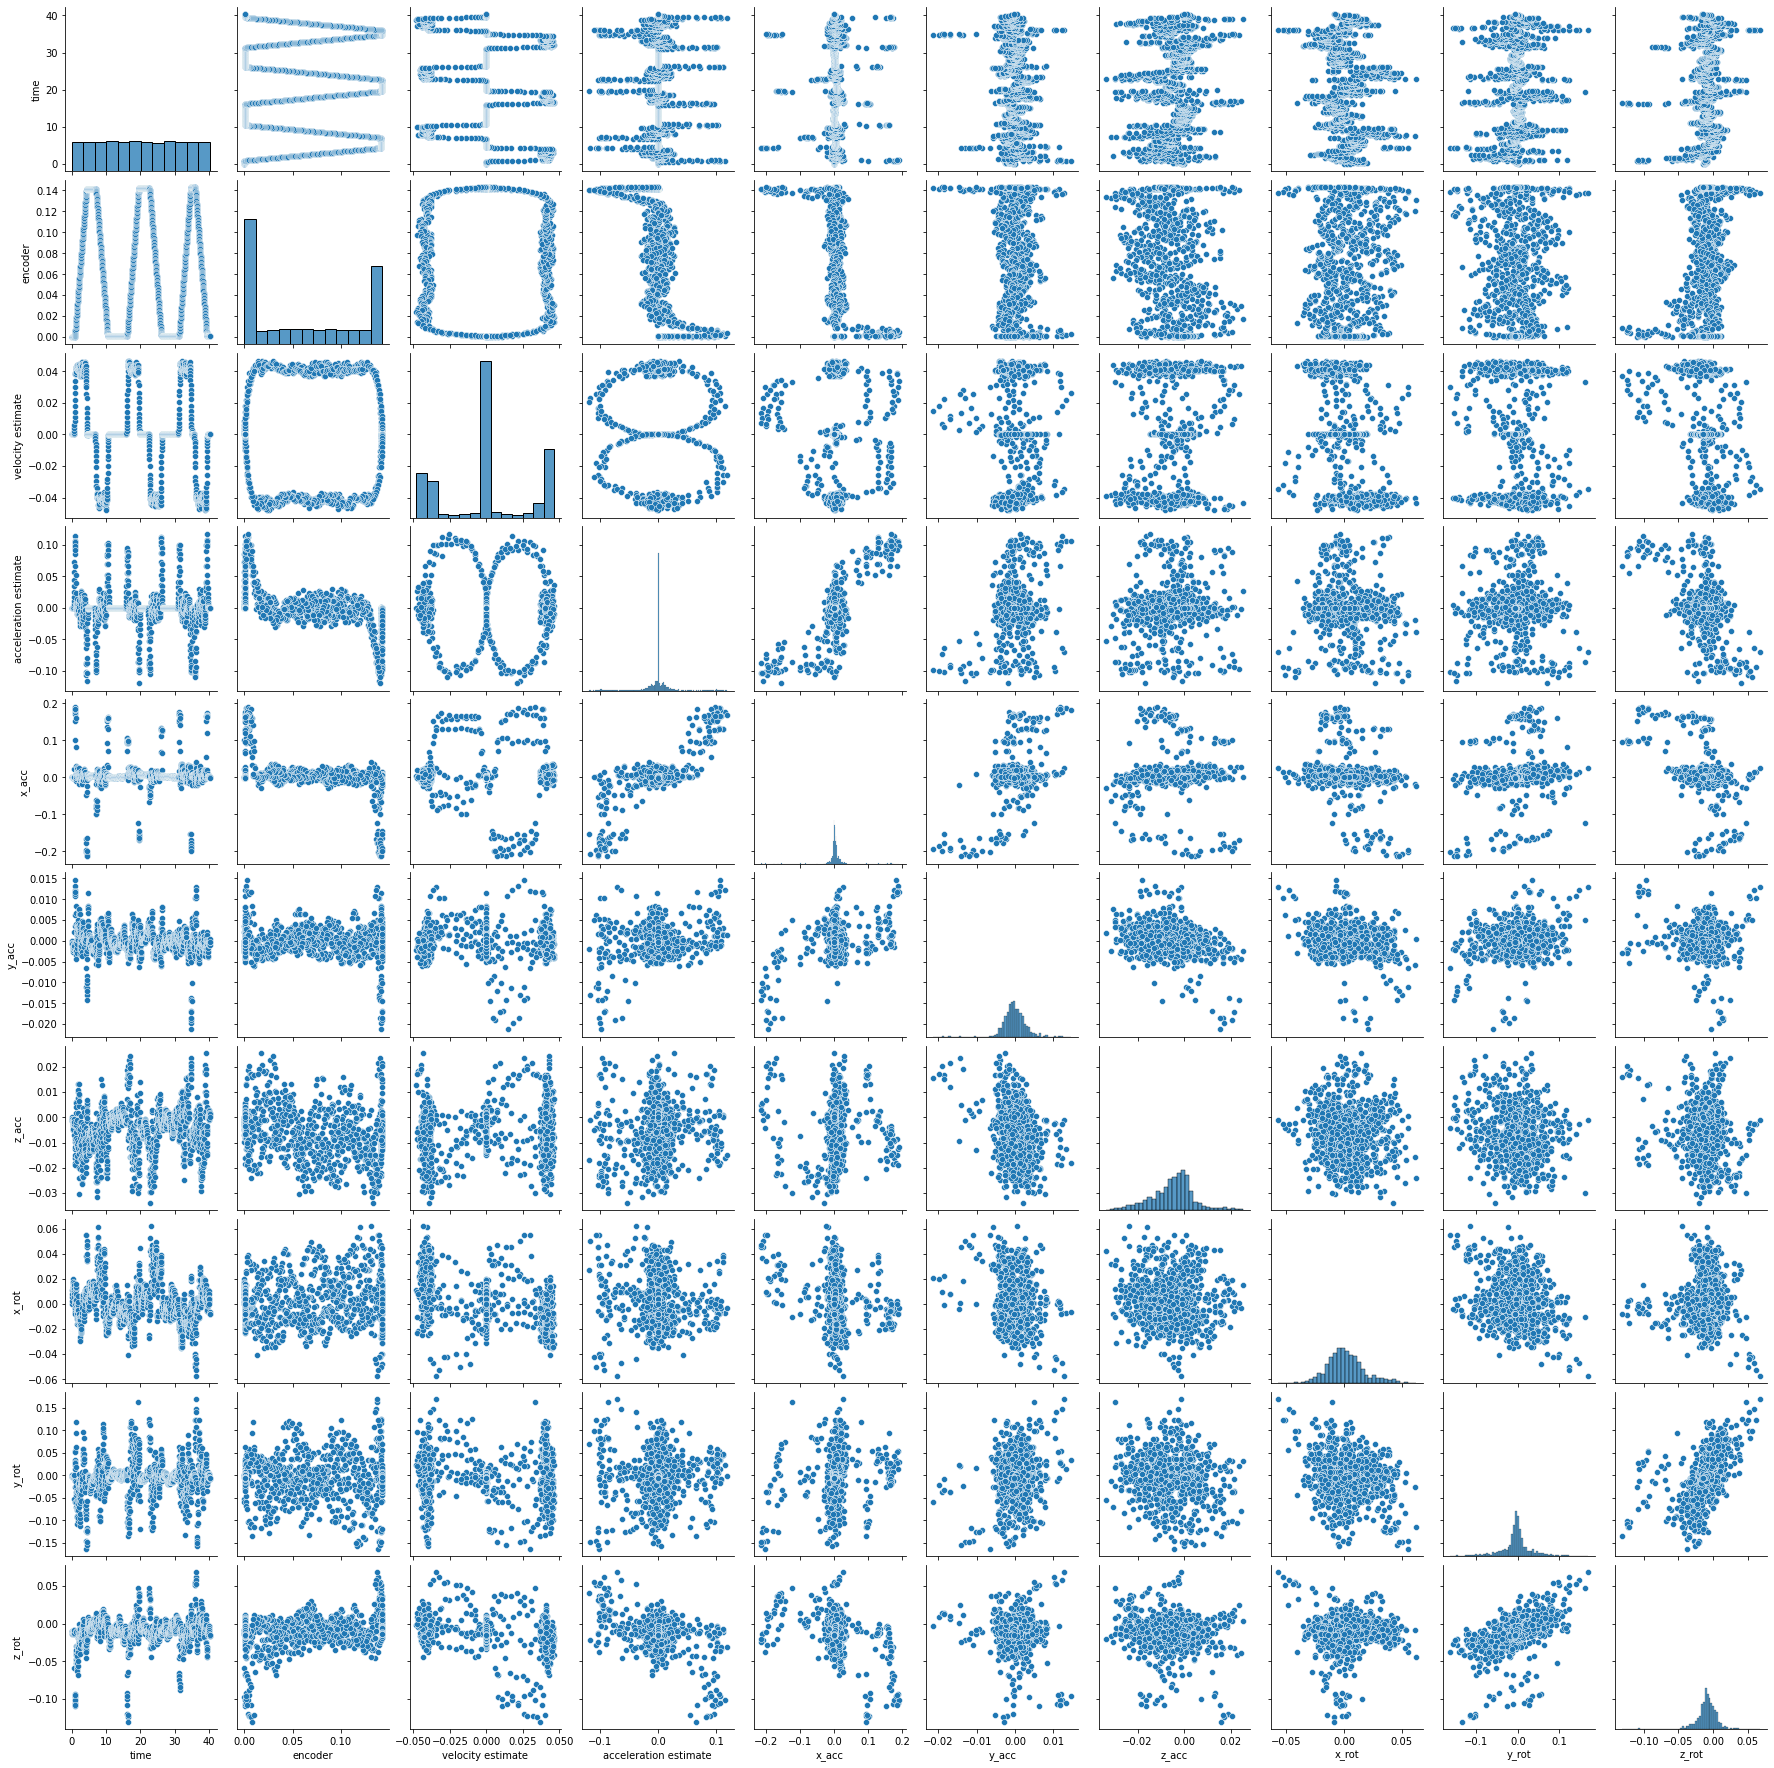

In [273]:
# final data

final_data = pd.DataFrame({"time": time, "encoder": position, "velocity estimate": velocity, "acceleration estimate": acceleration, "x_acc": x_acc, "y_acc": y_acc, "z_acc": z_acc, "x_rot": x_rot, "y_rot": y_rot, "z_rot": z_rot},columns=["time", "encoder", "velocity estimate", "acceleration estimate", "x_acc", "y_acc", "z_acc", "x_rot", "y_rot", "z_rot"])

corr_mat = final_data.corr()
mask = np.zeros_like(corr_mat, dtype=bool) 
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

sns.pairplot(final_data)
plt.show()